In [1]:
import psutil
import GPUtil

# Get CPU information
cpu_count = psutil.cpu_count(logical=True)
cpu_percent = psutil.cpu_percent(interval=1)

# Get Memory information
memory_info = psutil.virtual_memory()

# Get GPU information
gpus = GPUtil.getGPUs()

# Format GPU information
gpu_info = ""
for gpu in gpus:
    gpu_info += f"""
    GPU ID: {gpu.id}
    Name: {gpu.name}
    Total Memory: {gpu.memoryTotal} MB
    Available Memory: {gpu.memoryFree} MB
    Used Memory: {gpu.memoryUsed} MB
    GPU Load: {gpu.load * 100:.1f}%
    Temperature: {gpu.temperature} °C
    """

# Format the output
formatted_output = f"""
System Information:
--------------------
CPU:
- Total CPUs: {cpu_count}
- CPU Usage: {cpu_percent}%

Memory:
- Total Memory: {memory_info.total / (1024 ** 3):.2f} GB
- Available Memory: {memory_info.available / (1024 ** 3):.2f} GB
- Used Memory: {memory_info.used / (1024 ** 3):.2f} GB
- Memory Usage: {memory_info.percent}%

GPU:
{gpu_info}
"""

print(formatted_output)


System Information:
--------------------
CPU:
- Total CPUs: 32
- CPU Usage: 5.0%

Memory:
- Total Memory: 187.52 GB
- Available Memory: 177.42 GB
- Used Memory: 5.65 GB
- Memory Usage: 5.4%

GPU:

    GPU ID: 0
    Name: Tesla V100-SXM2-32GB
    Total Memory: 32768.0 MB
    Available Memory: 32490.0 MB
    Used Memory: 3.0 MB
    GPU Load: 0.0%
    Temperature: 38.0 °C
    



In [24]:
import os
import sys
sys.path.append(os.getcwd())

from tumorpde.models.deform import TumorDeformFD
from tumorpde.volume_domain import VolumeDomain

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"The current device is: {device}")

from datetime import datetime
import pandas as pd

from expriment_helpers import read_patient_data, weighted_center
from expriment_helpers import _vis_brain_scan

The current device is: cuda


In [5]:
patient = "WXS"
indexes = [1,2]
ref_scan = 1

In [6]:
data = read_patient_data(patient, test=0, mask_ids=indexes, ref=ref_scan)

Read data:
Patient brain, shape: (193, 229, 193)
Patient raw scan, shape: (193, 229, 193)
Grey matter, shape: (193, 229, 193)
White matter, shape: (193, 229, 193)
Tumor mask 1, shape: (193, 229, 193)
Tumor mask 2, shape: (193, 229, 193)


In [7]:
data_path = data["dir_path"]
brain_raw = data["t1"]
gm = data["gm"]
wm = data["wm"]
csf = data["csf"]
tumor_list = data["tumor"]
aff_info = data["aff_info"]
header = data["header"]
del data

In [10]:
matters = torch.cat([
    torch.tensor(gm, device=device).unsqueeze(0),
    torch.tensor(wm, device=device).unsqueeze(0),
    torch.tensor(csf, device=device).unsqueeze(0)
], dim=0)

In [11]:
geom = VolumeDomain((gm + wm + csf), [1.,1.,1.])

# Define the time domain
t0, t1 = 0., 1.

In [12]:
alpha = 20.
D = 100.
M = 1.
kappa = 1.
cx = weighted_center(tumor_list[0]) + 0.5  # initialized the center
D_ratio = 0.3
kappa_ratios = [0.1, 0.5]
print(f"Initial location: {cx}")
init_peak_height = 0.01
init_peak_width = 2.
init_density_params  = {"w": init_peak_width, "h": init_peak_height, "rmax": 4.}

Initial location: [ 55.02426343 114.12131716  94.51863085]


In [13]:
# create the PDE model
pde = TumorDeformFD(geom, matters,
                    D, alpha, M, kappa,
                    D_ratio, kappa_ratios,
                    init_learnable_params=cx,
                    init_other_params=init_density_params)

In [23]:
dt = 0.001
state, t = pde.solve(None, dt, t1 = 0.1)

/project/6006512/muye/env/torch/lib/python3.11/site-packages/torch/utils/_device.py:78: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /home/coulombc/wheels_builder/tmp.2617/python-3.11/torch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return func(*args, **kwargs)


In [ ]:
dt = 0.005
state, t = pde.solve(state, dt, t1 = 0.3)

Change dt to 0.0024999975000025.


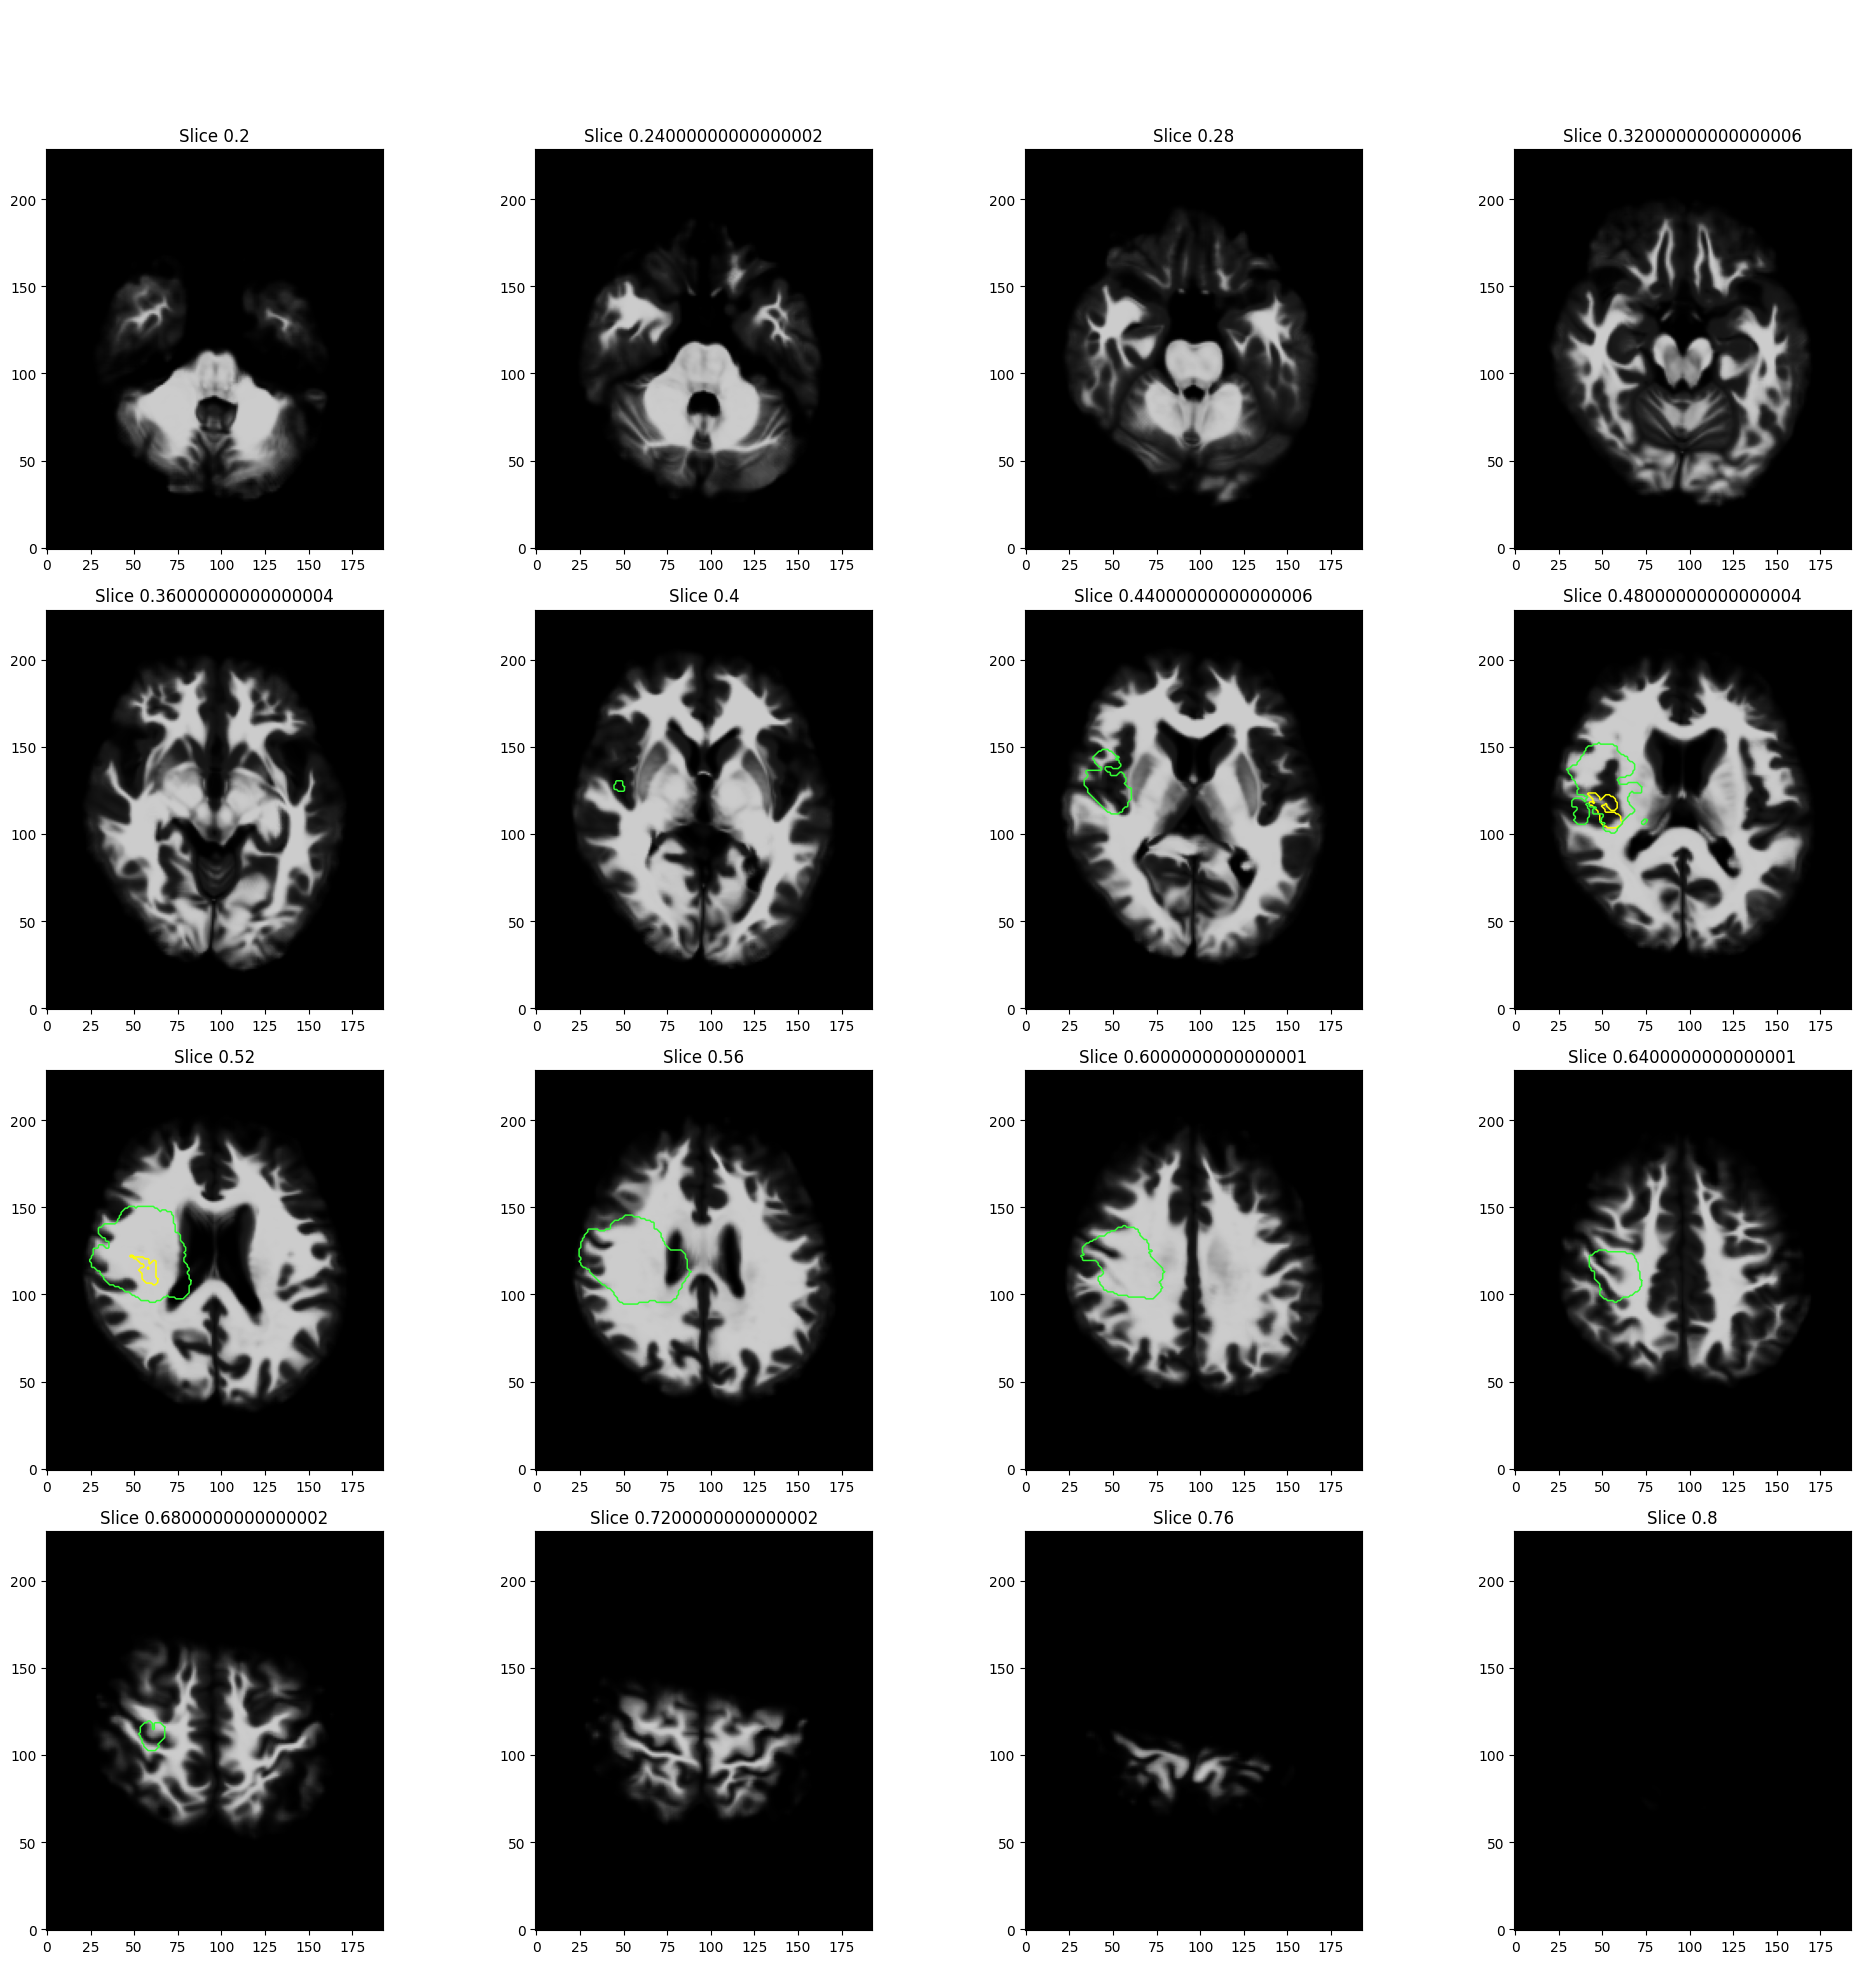

In [ ]:
tmp_brain = 0.1 * state.brain_density[0].detach().cpu().numpy() + \
    0.9 * state.brain_density[1].detach().cpu().numpy()
_vis_brain_scan(state.tumor_density.detach().cpu().numpy(),
                [tmp_brain], tumor_list, figsize=(5,5), main_title="")